In [9]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import matplotlib.colors as mcolors
from pyvis.network import Network
import networkx as nx
# Make a ListedColormap with your custom palette
from matplotlib.colors import ListedColormap
color_palette = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#FF69B4",  # bluish green
    "#00C0A3",  # yellow
    "#D55E00",  # vermillion
    "#D3D3FF",  # reddish purple
    "#32CD32", 
    "#F0E442",
    "#E40078",
    "#FF7F50"]  # grey
#800080
#FF7F50
#B98663
#F0E442

def export_pyvis_graph(G_nx, G_ig, walktrap_partition, output_html="walktrap_network_interactive.html"):
    """
    Create and export an interactive PyVis visualization of a NetworkX graph.
    Uses igraph's walktrap_partition and G_ig to map communities correctly.
    """
    net = Network(height="800px", width="100%", notebook=False)

    # Get igraph node names
    ig_names = G_ig.vs["name"]

    # Map igraph index → gene name → community ID
    community_map = {}
    for i, community in enumerate(walktrap_partition):
        for ig_idx in community:
            node_name = ig_names[ig_idx]
            community_map[node_name] = i

    # Add nodes with community-based color and styled font
    for node in G_nx.nodes:
        community = community_map.get(node, 0)
        net.add_node(
            node,
            label=node,
            title=f"<b>Gene:</b> {node}<br><b>Community:</b> {community}",
            color=f"hsl({(community * 137) % 360}, 70%, 60%)",
            font={"size": 50, "bold": True}
        )

    # Add edges with weights
    for u, v, data in G_nx.edges(data=True):
        net.add_edge(u, v, value=data.get("weight", 1.0))

    # Layout and export
    net.repulsion(node_distance=400, spring_length=300)
    net.show_buttons(filter_=['physics'])
    net.write_html(output_html, open_browser=True)
    print(f"Interactive graph saved as {output_html}")

def nx_to_igraph(G_nx):
    G_ig = ig.Graph()
    G_ig.add_vertices(list(G_nx.nodes))
    G_ig.add_edges(list(G_nx.edges))
    return G_ig

def get_node_to_community(partition, G_ig):
    node_to_comm = {}
    for i, community in enumerate(partition):
        for node in community:
            node_name = G_ig.vs[node]["name"]
            node_to_comm[node_name] = i
    return node_to_comm

def get_node_connections_and_weights(G):
    node_connection_dict = {}
    for node in G.nodes:
        connections = []
        for neighbor in G.neighbors(node):
            weight = G[node][neighbor]['weight']
            connections.append((neighbor, weight))
        node_connection_dict[node] = connections
    return node_connection_dict
    
def summarize_clusters_and_connections(G, partition, G_ig):
    node_to_comm = get_node_to_community(partition, G_ig)
    connections = get_node_connections_and_weights(G)

    summary = []
    for node in G.nodes:
        entry = {
            "Gene": node,
            "Cluster": node_to_comm.get(node, -1),
            "Connections": connections[node]
        }
        summary.append(entry)

    return pd.DataFrame(summary)

def plot_walktrap_community(G_nx, layout='spring', title="Ciliary Composite Score Gene Network (Walktrap Clustering)"):
    G_ig = nx_to_igraph(G_nx)

    # Compute Walktrap clustering
    walktrap = G_ig.community_walktrap()
    partition = walktrap.as_clustering()

    # Map colors to cluster IDs
    cluster_map = {}
    for i, community in enumerate(partition):
        for node in community:
            cluster_map[G_ig.vs[node]["name"]] = i
    node_colors = [cluster_map[node] for node in G_nx.nodes]

    # Layout
    pos = nx.spring_layout(G_nx, seed=42) if layout == 'spring' else nx.kamada_kawai_layout(G_nx)
    #pos = nx.kamada_kawai_layout(G_nx)
    #pos = nx.circular_layout(G_nx)
    # Edge weights for width
    weights = [G_nx[u][v]['weight'] for u, v in G_nx.edges]

    # Plot
    plt.figure(figsize=(16, 12)) 
   #plt.figure(figsize=(12, 10))
    #nx.draw_networkx_nodes(G_nx, pos, node_size=300, node_color=node_colors, cmap=plt.cm.tab20, alpha=0.9)

    cmap = ListedColormap(color_palette)
    
    # Normalize the color indices
    node_colors_normalized = [c % len(color_palette) for c in node_colors]
    
    # Plot with friendly palette
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        node_size=300,
        node_color=node_colors_normalized,
        cmap=cmap,
        alpha=0.9
    )
    nx.draw_networkx_edges(G_nx, pos, width=[w * 0.5 for w in weights], alpha=0.5)
    nx.draw_networkx_labels(G_nx, pos, font_size=7)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("walktrap_network.pdf", format="pdf", dpi=300)  # Also try .png or .svg
    plt.show()

    return partition

def get_top_gene_partners(df, top_n=5):
    # Make sure columns are named as expected
    assert {"Gene_A", "Gene_B", "composite_score"}.issubset(df.columns)

    # Duplicate the dataframe to treat Gene_A and Gene_B symmetrically
    df_a = df[["Gene_A", "Gene_B", "composite_score"]].rename(columns={"Gene_A": "Gene", "Gene_B": "Partner"})
    df_b = df[["Gene_B", "Gene_A", "composite_score"]].rename(columns={"Gene_B": "Gene", "Gene_A": "Partner"})
    combined = pd.concat([df_a, df_b], axis=0)
    #display(combined)

    # # Group by Gene and get top N partners by score
    top_partners = (
        combined.sort_values(by=["Gene", "composite_score"], ascending=[True, False])
        .groupby("Gene")
        .head(top_n)
    )

    #print(top_partners)

    # Build final output
    def format_row(group):
        partners = group["Partner"].tolist()
        scores = group["composite_score"].tolist()
        row = {"Gene": group["Gene"].iloc[0]}
        for i in range(top_n):
            row[f"Top_{i+1}"] = partners[i] if i < len(partners) else None
            row[f"Score_{i+1}"] = scores[i] if i < len(scores) else None
        return pd.Series(row)

    result = top_partners.groupby("Gene").apply(format_row).reset_index(drop=True)[['Gene', 'Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5', 'Score_1', 'Score_2',  'Score_3', 'Score_4', 'Score_5']]
    return result

def export_graph_stats(G_nx, G_ig, walktrap_partition, output_csv="gene_network_stats.csv"):
    # Map igraph index → gene name
    igraph_names = G_ig.vs["name"]

    # Build community mapping using igraph node names
    community_map = {}
    for i, community in enumerate(walktrap_partition):
        for ig_idx in community:
            gene = igraph_names[ig_idx]
            community_map[gene] = i

    # Degree (unweighted and weighted)
    degrees = dict(G_nx.degree())
    weighted_degrees = dict(G_nx.degree(weight='weight'))
    betweenness = nx.betweenness_centrality(G_nx, weight='weight', normalized=True)

    # Build dataframe
    records = []
    for node in G_nx.nodes:
        records.append({
            "Gene": node,
            "Community": community_map.get(node),
            "Degree": degrees.get(node, 0),
            "Weighted_Degree": weighted_degrees.get(node, 0.0),
            "Betweenness": betweenness.get(node, 0.0)
        })

    df_stats = pd.DataFrame(records)
    df_stats.to_csv(output_csv, index=False)
    print(f"Exported: {output_csv}")
    return df_stats



In [2]:
df = pd.read_csv('cilia_rf_n10000_phylo_composite.csv')

In [3]:
top_gene_partners = get_top_gene_partners(df).sort_values(by = 'Score_1', ascending=False)

/tmp/ipykernel_136848/3475512414.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = top_partners.groupby("Gene").apply(format_row).reset_index(drop=True)[['Gene', 'Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5', 'Score_1', 'Score_2',  'Score_3', 'Score_4', 'Score_5']]


In [4]:
top_gene_partners

,Gene,Top_1,Top_2,Top_3,Top_4,Top_5,Score_1,Score_2,Score_3,Score_4,Score_5
235,RAN,HSPA8,TUBA1C,ACTR3,RANBP1,RAB11A,9.238973,8.633664,7.271485,7.009451,6.989994
125,HSPA8,RAN,TUBA1A,RANBP1,ACTR3,ARF4,9.238973,8.307611,4.505740,4.109750,4.058449
230,RAB1A,RAB11A,ATP6V1D,TRAPPC3,RAB10,ARF4,8.747728,8.598499,7.357083,6.790013,6.449047
225,RAB11A,RAB1A,ATP6V1D,RAN,RAB10,GSK3B,8.747728,7.102969,6.989994,6.671057,6.560259
315,TUBA1C,RAN,MAPRE1,PLK1,ACTR3,TUBA4A,8.633664,7.917663,7.689455,6.550776,5.949861
...,...,...,...,...,...,...,...,...,...,...,...
213,PKHD1,DCDC2,EVC,HNF1B,RP1,RP1,1.332452,0.502020,0.256532,0.178759,0.165389
90,DRD2,NUP35,DRD1,PDZD7,SPA17,PKD2L1,1.317617,1.255802,1.175847,1.149323,1.148477
329,UMOD,RP1,SCNN1A,SPA17,HNF1B,IQCB1,1.258720,1.016848,0.986603,0.949167,0.847123
177,NGFR,MAL,BBIP1,ALMS1,NIN,PKD1,1.256635,1.111570,0.874923,0.705810,0.683308


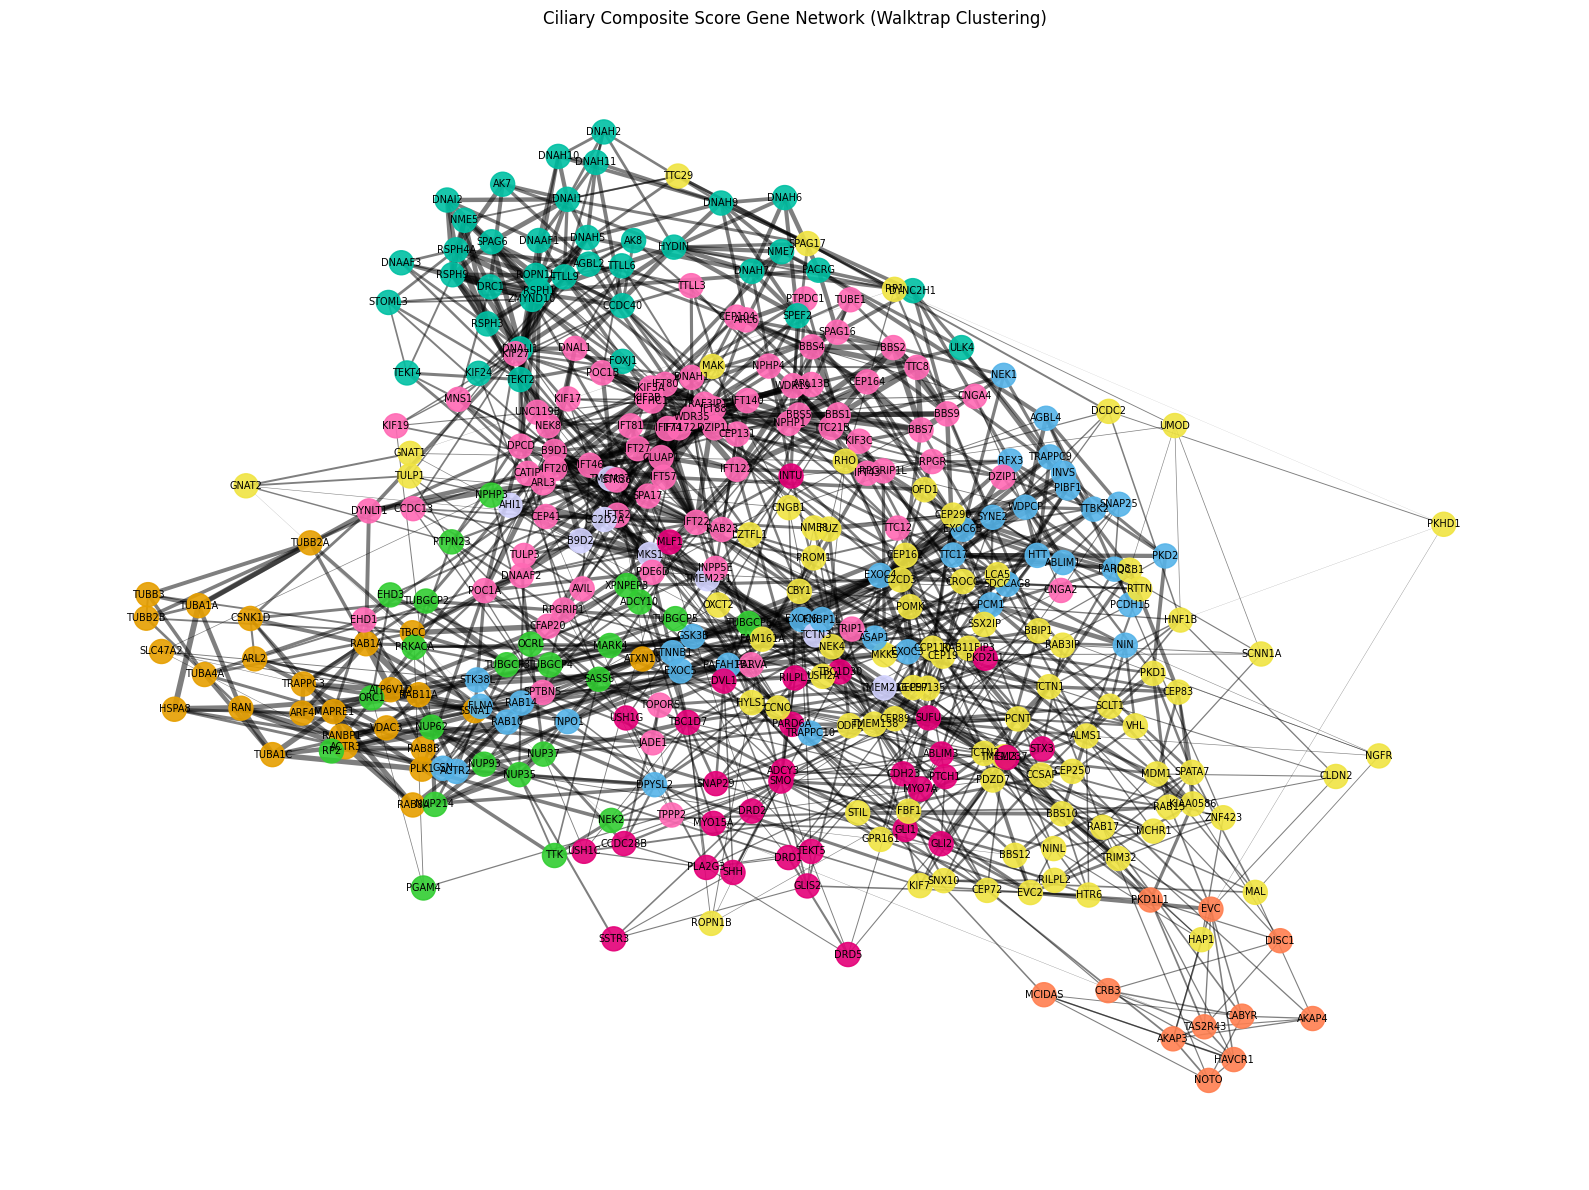

,Gene,Cluster,Connections
0,RAN,0,"[(HSPA8, 9.238972687293243), (TUBA1C, 8.633664..."
1,HSPA8,0,"[(RAN, 9.238972687293243), (TUBA1A, 8.30761071..."
2,TUBA1C,0,"[(RAN, 8.63366435237726), (MAPRE1, 7.917662889..."
3,ACTR3,0,"[(RAN, 7.271484538252391), (HSPA8, 4.109750266..."
4,RANBP1,0,"[(RAN, 7.0094510198600855), (HSPA8, 4.50573968..."
...,...,...,...
337,SLC47A2,0,"[(ATP6V1D, 1.6031064923868257), (STK38L, 1.340..."
338,ROPN1B,6,"[(FAM161A, 1.352522711255033), (TBC1D7, 1.2530..."
339,PKHD1,6,"[(DCDC2, 1.332451917938236), (EVC, 0.502019679..."
340,NGFR,6,"[(MAL, 1.2566353319997443), (BBIP1, 1.11157013..."


In [7]:
# Step 1: Build the graph from top_df
import pandas as pd
import networkx as nx

def build_graph_from_top_df(top_df, top_n=5):
    G = nx.Graph()
    for _, row in top_df.iterrows():
        gene = row['Gene']
        for i in range(1, top_n + 1):
            partner = row.get(f'Top_{i}')
            score = row.get(f'Score_{i}')
            if pd.notnull(partner) and pd.notnull(score):
                G.add_edge(gene, partner, weight=score)
    return G

# Example: construct graph
G = build_graph_from_top_df(top_gene_partners, top_n=5)

# Step 2: Run the Walktrap clustering visualization
partition = plot_walktrap_community(G, layout='spring')

G_ig = nx_to_igraph(G)
summary_df = summarize_clusters_and_connections(G, partition, G_ig)
summary_df

In [8]:
print(f"Number of Walktrap communities: {len(partition)}")
print(f"Walktrap modularity: {partition.modularity:.4f}")


Number of Walktrap communities: 9
Walktrap modularity: 0.5374


In [151]:
# Build the NetworkX graph
G_nx = build_graph_from_top_df(top_gene_partners, top_n=5)

# Convert to igraph and run walktrap
G_ig = nx_to_igraph(G_nx)
walktrap = G_ig.community_walktrap()
walktrap_partition = walktrap.as_clustering()

# Export the gene stats
df_stats = export_graph_stats(G_nx, G_ig, walktrap_partition, output_csv="walktrap_gene_communities.csv")


Exported: walktrap_gene_communities.csv


In [169]:

export_pyvis_graph(G_nx, G_ig, walktrap_partition, output_html="walktrap_network_interactive_.html")


Interactive graph saved as walktrap_network_interactive_.html


In [72]:
#WALKTRAP_SUMMARY = summary_df.merge(com, on = 'Gene').drop(columns=['Cluster'])
# com = pd.read_csv('walktrap_gene_communities.csv')

In [10]:
WALKTRAP_SUMMARY=pd.read_csv('walktrap_cilia_summary.csv')

In [72]:
WALKTRAP_SUMMARY = summary_df.merge(com, on = 'Gene').drop(columns=['Cluster'])

In [11]:
class AFMCandidateSelector:
    def __init__(self, G, cluster_map):
        """
        Parameters:
            G (networkx.Graph): Weighted gene interaction graph
            cluster_map (dict): Maps gene -> cluster ID (e.g., from Walktrap)
        """
        self.G = G
        self.cluster_map = cluster_map
        self.weighted_degree = dict(G.degree(weight='weight'))
        self.betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

    def get_top_afm_candidates(self, top_k=10, n_first_neighbors=5, min_shared_neighbors=3):
        results = []

        # Group nodes by cluster
        clusters = {}
        for node, c in self.cluster_map.items():
            clusters.setdefault(c, []).append(node)

        for cluster_id, nodes in clusters.items():
            subgraph = self.G.subgraph(nodes)

            # Get top-k by each metric
            top_by_wdeg = sorted(nodes, key=lambda x: self.weighted_degree.get(x, 0), reverse=True)[:top_k]
            top_by_btwn = sorted(nodes, key=lambda x: self.betweenness.get(x, 0), reverse=True)[:top_k]
            top_genes = set(top_by_wdeg + top_by_btwn)

            for gene in top_genes:
                # --- First-degree neighbors ---
                first_neighbors = sorted(
                    subgraph[gene].items(),
                    key=lambda x: x[1].get('weight', 0),
                    reverse=True
                )[:n_first_neighbors]

                for neighbor, attrs in first_neighbors:
                    results.append({
                        'candidate_gene_1': gene,
                        'candidate_gene_2': neighbor,
                        'weighted_degree_1': self.weighted_degree[gene],
                        'betweenness_1': self.betweenness[gene],
                        'weighted_degree_2': self.weighted_degree[neighbor],
                        'betweenness_2': self.betweenness[neighbor],
                        'neighbor_type': 'first',
                        'shared_neighbors': len(set(self.G.neighbors(gene)) & set(self.G.neighbors(neighbor)))
                    })

                # --- Second-degree neighbors (strong triangle closure) ---
                neighbors_1st = set(self.G.neighbors(gene))
                neighbors_2nd = set()
                for n in neighbors_1st:
                    neighbors_2nd.update(self.G.neighbors(n))
                neighbors_2nd -= neighbors_1st | {gene}

                for second_neighbor in neighbors_2nd:
                    shared = set(self.G.neighbors(gene)) & set(self.G.neighbors(second_neighbor))
                    if len(shared) >= min_shared_neighbors and not self.G.has_edge(gene, second_neighbor):
                        results.append({
                            'candidate_gene_1': gene,
                            'candidate_gene_2': second_neighbor,
                            'weighted_degree_1': self.weighted_degree[gene],
                            'betweenness_1': self.betweenness[gene],
                            'weighted_degree_2': self.weighted_degree[second_neighbor],
                            'betweenness_2': self.betweenness[second_neighbor],
                            'neighbor_type': 'second',
                            'shared_neighbors': len(shared)
                        })

        return pd.DataFrame(results)

In [13]:
# After running Walktrap
partition = G_ig.community_walktrap().as_clustering()
ig_names = G_ig.vs["name"]

# Build cluster_map
cluster_map = {}
for cluster_id, community in enumerate(partition):
    for idx in community:
        gene = ig_names[idx]
        cluster_map[gene] = cluster_id

In [14]:
cluster_map

{'RAN': 0,
 'HSPA8': 0,
 'TUBA1C': 0,
 'ACTR3': 0,
 'RANBP1': 0,
 'RAB11A': 0,
 'TUBA1A': 0,
 'ARF4': 0,
 'RAB1A': 0,
 'ATP6V1D': 0,
 'TRAPPC3': 0,
 'MAPRE1': 0,
 'PLK1': 0,
 'TUBA4A': 0,
 'RAB8B': 0,
 'TUBB2A': 0,
 'TUBB3': 0,
 'RAB8A': 0,
 'CSNK1D': 0,
 'TBCC': 0,
 'TUBB2B': 0,
 'ARL2': 0,
 'VDAC3': 0,
 'SSNA1': 0,
 'ATXN10': 0,
 'SLC47A2': 0,
 'RAB10': 1,
 'GSK3B': 1,
 'ACTR2': 1,
 'RAB14': 1,
 'DPYSL2': 1,
 'EXOC4': 1,
 'EXOC6': 1,
 'EXOC5': 1,
 'EXOC3': 1,
 'EXOC6B': 1,
 'PAFAH1B1': 1,
 'TTC17': 1,
 'TNPO1': 1,
 'PARD3': 1,
 'HTT': 1,
 'WDPCP': 1,
 'RFX3': 1,
 'PCM1': 1,
 'AGBL4': 1,
 'INVS': 1,
 'TTBK2': 1,
 'TRAPPC9': 1,
 'SDCCAG8': 1,
 'PIBF1': 1,
 'NIN': 1,
 'ASAP1': 1,
 'SNAP25': 1,
 'PCDH15': 1,
 'PKD2': 1,
 'FNBP1L': 1,
 'CTNNB1': 1,
 'ABLIM1': 1,
 'STK38L': 1,
 'NEK1': 1,
 'TRAPPC10': 1,
 'SYNE2': 1,
 'GSN': 1,
 'FLNA': 1,
 'CLUAP1': 2,
 'IFT46': 2,
 'IFT88': 2,
 'IFT172': 2,
 'IFT57': 2,
 'TRAF3IP1': 2,
 'IFT52': 2,
 'TTC21B': 2,
 'WDR35': 2,
 'IFT140': 2,
 'IFT122': 2,
 

In [15]:
G

In [18]:
selector = AFMCandidateSelector(G, cluster_map)
afm_candidates = selector.get_top_afm_candidates(
    top_k=10,
    n_first_neighbors=5,
    min_shared_neighbors=3
)
afm_candidates

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
0,PLK1,TUBA1C,34.594573,0.005348,41.219445,0.000052,first,2
1,PLK1,MAPRE1,34.594573,0.005348,63.631303,0.002243,first,1
2,PLK1,SSNA1,34.594573,0.005348,28.943390,0.005365,first,2
3,RAB1A,RAB11A,58.577790,0.001466,62.715677,0.000621,first,3
4,RAB1A,ATP6V1D,58.577790,0.001466,50.998125,0.004554,first,4
...,...,...,...,...,...,...,...,...
923,MCIDAS,AKAP3,8.968189,0.004382,18.129452,0.005434,first,2
924,MCIDAS,HAVCR1,8.968189,0.004382,14.301102,0.006089,first,2
925,MCIDAS,NOTO,8.968189,0.004382,9.487996,0.001294,first,3
926,MCIDAS,CABYR,8.968189,0.004382,11.855550,0.003623,first,1


In [37]:
afm_candidates = selector.get_top_afm_candidates(
    top_k=5,
    n_first_neighbors=5,
    min_shared_neighbors=3
)
afm_candidates

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
0,RAB1A,RAB11A,58.577790,0.001466,62.715677,0.000621,first,3
1,RAB1A,ATP6V1D,58.577790,0.001466,50.998125,0.004554,first,4
2,RAB1A,TRAPPC3,58.577790,0.001466,54.574739,0.010212,first,3
3,RAB1A,ARF4,58.577790,0.001466,40.075296,0.000155,first,3
4,RAB1A,CSNK1D,58.577790,0.001466,25.037478,0.002191,first,2
...,...,...,...,...,...,...,...,...
528,CRB3,TAS2R43,9.270838,0.016405,15.175787,0.046369,first,2
529,CRB3,HAVCR1,9.270838,0.016405,14.301102,0.006089,first,1
530,CRB3,DISC1,9.270838,0.016405,8.635891,0.015146,first,1
531,CRB3,PKD1L1,9.270838,0.016405,23.913688,0.002243,second,3


In [38]:
afm_candidates[afm_candidates['candidate_gene_1']=='DNALI1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
237,DNALI1,RSPH1,111.116011,0.026427,107.720411,0.001863,first,10
238,DNALI1,DRC1,111.116011,0.026427,48.280623,0.002139,first,3
239,DNALI1,ZMYND10,111.116011,0.026427,74.376255,0.003519,first,8
240,DNALI1,RSPH9,111.116011,0.026427,81.227225,0.000983,first,6
241,DNALI1,SPAG6,111.116011,0.026427,48.682874,0.000000,first,3
242,DNALI1,STOML3,111.116011,0.026427,18.212127,0.005606,second,5
243,DNALI1,CCDC40,111.116011,0.026427,54.114280,0.016026,second,3
244,DNALI1,DNAI2,111.116011,0.026427,36.687155,0.000086,second,4
245,DNALI1,NME5,111.116011,0.026427,37.309611,0.000138,second,3
246,DNALI1,ARL3,111.116011,0.026427,61.048870,0.003605,second,5


In [39]:
afm_candidates[afm_candidates['candidate_gene_2']=='DNALI1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
254,ZMYND10,DNALI1,74.376255,0.003519,111.116011,0.026427,first,8
272,CCDC40,DNALI1,54.114280,0.016026,111.116011,0.026427,second,3
278,RSPH1,DNALI1,107.720411,0.001863,111.116011,0.026427,first,10
291,HYDIN,DNALI1,71.611825,0.015750,111.116011,0.026427,first,2
303,RSPH9,DNALI1,81.227225,0.000983,111.116011,0.026427,first,6


In [40]:
afm_candidates[afm_candidates['candidate_gene_1']=='B9D1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
176,B9D1,ARL3,118.363978,0.007711,61.048870,0.003605,first,3
177,B9D1,EFHC1,118.363978,0.007711,70.077482,0.018613,first,2
178,B9D1,POC1A,118.363978,0.007711,46.664260,0.003243,first,1
179,B9D1,KIF3B,118.363978,0.007711,40.066084,0.008211,first,1
180,B9D1,DNAL1,118.363978,0.007711,40.151516,0.000811,first,4
181,B9D1,RSPH4A,118.363978,0.007711,70.966901,0.000466,second,3
182,B9D1,TCTN3,118.363978,0.007711,32.139760,0.000052,second,3
183,B9D1,RSPH9,118.363978,0.007711,81.227225,0.000983,second,3
184,B9D1,IFT22,118.363978,0.007711,135.946556,0.028014,second,4
185,B9D1,RSPH1,118.363978,0.007711,107.720411,0.001863,second,4


In [42]:
afm_candidates[afm_candidates['candidate_gene_1']=='RSPH1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
275,RSPH1,RSPH3,107.720411,0.001863,50.124092,0.002070,first,4
276,RSPH1,RSPH4A,107.720411,0.001863,70.966901,0.000466,first,7
277,RSPH1,RSPH9,107.720411,0.001863,81.227225,0.000983,first,8
278,RSPH1,DNALI1,107.720411,0.001863,111.116011,0.026427,first,10
279,RSPH1,ZMYND10,107.720411,0.001863,74.376255,0.003519,first,7
280,RSPH1,DNAI2,107.720411,0.001863,36.687155,0.000086,second,3
281,RSPH1,FOXJ1,107.720411,0.001863,22.674146,0.000121,second,4
282,RSPH1,SPA17,107.720411,0.001863,35.284420,0.056874,second,4
283,RSPH1,TEKT4,107.720411,0.001863,16.486129,0.009056,second,3
284,RSPH1,B9D1,107.720411,0.001863,118.363978,0.007711,second,4


In [28]:
afm_candidates[afm_candidates['candidate_gene_1']=='GNAT1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
389,GNAT1,GNAT2,5.864257,0.0793,8.646459,0.020838,first,1
390,GNAT1,RHO,5.864257,0.0793,7.985753,0.022236,first,2
391,GNAT1,USH2A,5.864257,0.0793,18.792496,0.021166,first,1
392,GNAT1,TULP1,5.864257,0.0793,12.472730,0.068001,first,1
393,GNAT1,RP1,5.864257,0.0793,16.914547,0.098810,first,1


In [43]:
afm_candidates[afm_candidates['candidate_gene_1']=='RP1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
437,RP1,TTC29,16.914547,0.09881,17.038926,0.008711,first,1
438,RP1,SPAG17,16.914547,0.09881,28.048798,0.004502,first,2
439,RP1,RHO,16.914547,0.09881,7.985753,0.022236,first,1
440,RP1,UMOD,16.914547,0.09881,5.058460,0.068087,first,0
441,RP1,GNAT1,16.914547,0.09881,5.864257,0.079300,first,1


In [29]:
afm_candidates.to_csv("afm_candidates_533.csv",index=False)

In [44]:
afm_candidates = selector.get_top_afm_candidates(
    top_k=3,
    n_first_neighbors=3,
    min_shared_neighbors=4
)
afm_candidates

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
0,ACTR3,MAPRE1,68.630193,0.023840,63.631303,0.002243,first,3
1,ACTR3,RAN,68.630193,0.023840,55.312205,0.000759,first,2
2,ACTR3,TUBA1C,68.630193,0.023840,41.219445,0.000052,first,2
3,ACTR3,RANBP1,68.630193,0.023840,37.579426,0.000776,second,4
4,ACTR3,ATP6V1D,68.630193,0.023840,50.998125,0.004554,second,4
...,...,...,...,...,...,...,...,...
177,PKD1L1,DISC1,23.913688,0.002243,8.635891,0.015146,first,2
178,PKD1L1,EVC,23.913688,0.002243,24.280329,0.052562,second,4
179,CRB3,CABYR,9.270838,0.016405,11.855550,0.003623,first,0
180,CRB3,TAS2R43,9.270838,0.016405,15.175787,0.046369,first,2


In [46]:
afm_candidates[afm_candidates['candidate_gene_1']=='RP1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
146,RP1,TTC29,16.914547,0.09881,17.038926,0.008711,first,1
147,RP1,SPAG17,16.914547,0.09881,28.048798,0.004502,first,2
148,RP1,RHO,16.914547,0.09881,7.985753,0.022236,first,1


In [47]:
afm_candidates[afm_candidates['candidate_gene_2']=='RP1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
145,PKHD1,RP1,2.256392,0.084078,16.914547,0.09881,first,0


In [48]:
afm_candidates[afm_candidates['candidate_gene_1']=='GNAT1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
132,GNAT1,GNAT2,5.864257,0.0793,8.646459,0.020838,first,1
133,GNAT1,RHO,5.864257,0.0793,7.985753,0.022236,first,2
134,GNAT1,USH2A,5.864257,0.0793,18.792496,0.021166,first,1


In [51]:
afm_candidates[afm_candidates['candidate_gene_2']=='TUPL1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors


In [36]:
afm_candidates.to_csv('afm_candidates_182.csv',index=False)

In [45]:
afm_candidates[afm_candidates['candidate_gene_1']=='DNALI1']

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
79,DNALI1,RSPH1,111.116011,0.026427,107.720411,0.001863,first,10
80,DNALI1,DRC1,111.116011,0.026427,48.280623,0.002139,first,3
81,DNALI1,ZMYND10,111.116011,0.026427,74.376255,0.003519,first,8
82,DNALI1,STOML3,111.116011,0.026427,18.212127,0.005606,second,5
83,DNALI1,DNAI2,111.116011,0.026427,36.687155,0.000086,second,4
84,DNALI1,ARL3,111.116011,0.026427,61.048870,0.003605,second,5
85,DNALI1,ROPN1L,111.116011,0.026427,42.608079,0.003536,second,5
86,DNALI1,RSPH3,111.116011,0.026427,50.124092,0.002070,second,4
87,DNALI1,EFHC1,111.116011,0.026427,70.077482,0.018613,second,5


In [52]:
afm_candidates

,candidate_gene_1,candidate_gene_2,weighted_degree_1,betweenness_1,weighted_degree_2,betweenness_2,neighbor_type,shared_neighbors
0,ACTR3,MAPRE1,68.630193,0.023840,63.631303,0.002243,first,3
1,ACTR3,RAN,68.630193,0.023840,55.312205,0.000759,first,2
2,ACTR3,TUBA1C,68.630193,0.023840,41.219445,0.000052,first,2
3,ACTR3,RANBP1,68.630193,0.023840,37.579426,0.000776,second,4
4,ACTR3,ATP6V1D,68.630193,0.023840,50.998125,0.004554,second,4
...,...,...,...,...,...,...,...,...
177,PKD1L1,DISC1,23.913688,0.002243,8.635891,0.015146,first,2
178,PKD1L1,EVC,23.913688,0.002243,24.280329,0.052562,second,4
179,CRB3,CABYR,9.270838,0.016405,11.855550,0.003623,first,0
180,CRB3,TAS2R43,9.270838,0.016405,15.175787,0.046369,first,2
